In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

In [3]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 11.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-i7el7oot
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-i7el7oot
  Resolved https://github.com/vanbreugel-lab/pybounds to commit a2a55f7d1bcb0962b780d9973b2bc2ada29589de
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19534 sha256=98b667c32cb4c07fb37909661f5c6095e462032d92634cebad319060c5949bc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ehgq3hgv/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [9]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
linear_kalman_filter_helper_functions = import_local_or_github('linear_kalman_filter_helper_functions',
                                                               giturl='https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Lesson_5_Discrete_Linear_Kalman_Filter/linear_kalman_filter_helper_functions.py')

Fetching from: 
<Response [200]>


# Planar drone dynamics

Now all the drone dynamics are in the helper file, `planar_drone.py`

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

Last lesson we used a GPS to do our estimates:

$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix}
$

Now apply your linear discrete kalman filter to a scenario where you do not have a GPS, instead, you have a camera and an IMU. That is, your measurements look like:

$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[red]{\ddot{x}} \\[0.3em]
\bbox[red]{\ddot{z}} \\[0.3em]
\end{bmatrix} =
\begin{bmatrix}
\bbox[yellow]{\dot{x}/z} \\[0.3em]
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
\end{bmatrix} +
\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m} \\[0.3em]
\end{bmatrix} \bbox[lightgreen]{j_2}
$

# Exercises

For these exercises you probably want to copy your linearization notebook from Lesson 4 and edit that directly. Copy over any code you need from the kalman filter notebook (or save those functions to a `.py` file for cleaner operation).  

1. Simulate the drone with the new measurement set. Try writing your own function `h(x, u)` that returns the array of measurements. If you really get stuck, the function is in `../Utility/planar_drone.py` (which is already imported)
2. Add sensor noise.
3. Build a new linear model. Hint: the linear model for the dynamics is the same, but the linear model for C, D is different.
4. Define your R and Q matrices. Make it easy to test different Q matrices.
5. You can skip the saving / loading data and just do everything in the one notebook.
6. Run your linear kalman filter.
7. Look at some states, particularly: $[\theta, \dot{x}, z, k]$
8. Can you make your KF work by tuning Q, like we could for the GPS example?

# Solution

First -- save the following functions into a `.py` file to keep the notebook clean. Good practice: once you have a function you like, pull it out of the notebook.
  * rk4_discretize
  * jacobian_numerical
  * linear_discrete_kalman_forward_update
  * linear_discrete_kalman_filter

In [10]:
ls

linear_kalman_filter_helper_functions.py  plot_utility.py  sample_data/
planar_drone.py                           __pycache__/


In [11]:
from linear_kalman_filter_helper_functions import rk4_discretize, jacobian_numerical
from linear_kalman_filter_helper_functions import linear_discrete_kalman_forward_update, linear_discrete_kalman_filter

# Dynamics and measurement functions

In [12]:
f = planar_drone.F().f

In [13]:
# Option 1: pull the function from planar drone:
h = planar_drone.H('h_camera_imu').h

In [14]:
# Option 2: write the function here, but you will need the parameters.. let's pull them from planar_drone.py
g = planar_drone.g
m = planar_drone.m
L = planar_drone.L

In [15]:
def h_camera_imu(x_vec, u_vec, g=g, m=m, L=L):

    # Extract state variables
    theta = x_vec[0]
    theta_dot = x_vec[1]
    x = x_vec[2]
    x_dot = x_vec[3]
    z = x_vec[4]
    z_dot = x_vec[5]
    k = x_vec[6]

    # Extract control inputs
    j1 = u_vec[0]
    j2 = u_vec[1]

    # Model for acceleration -- these come from the model
    accel_x = -k * np.sin(theta) / m
    accel_z = -g + k * np.cos(theta) / m

    # Measurements
    y_vec = np.array([x_dot/z, theta, theta_dot, accel_x, accel_z])

    # Return measurement
    return y_vec

In [16]:
h = h_camera_imu

# Run MPC simulation

In [18]:
measurement_names = ['optic_flow', 'theta', 'theta_dot', 'accel_x', 'accel_z']
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h=h, tsim_length=20, dt=0.1,
                                                                    measurement_names=measurement_names)

### plot the x, z trajectory

Text(0, 0.5, 'z pos')

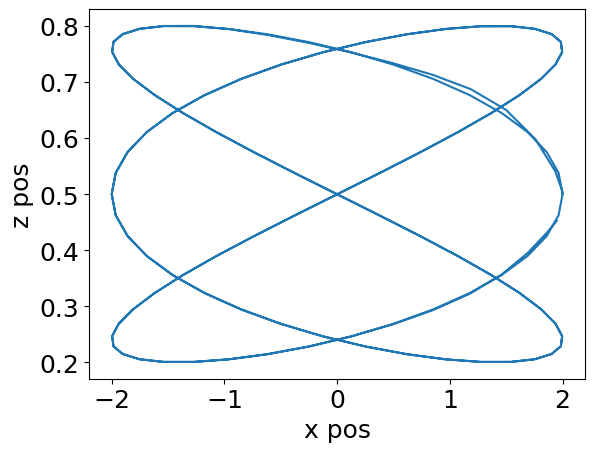

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

# Simulate noisy measurements

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [20]:
measurement_noise_stds = {'optic_flow': 0.2,
                          'theta': 0.1,
                          'theta_dot': 0.1,
                          'accel_x': 0.1,
                          'accel_z': 0.1,
                         }

In [21]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

### Plot some noisy measurements

<Axes: xlabel='Time', ylabel='optic_flow'>

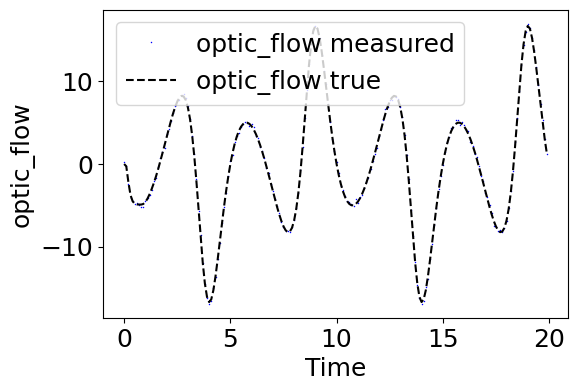

In [22]:
plot_tme(t_sim, y_sim['optic_flow'], y_noisy['optic_flow'], label_var='optic_flow')

# Prepare for a linear discrete time kalman filter

### Linearize the dynamics and measurement function

We need linearized dynamics of the form:

$
\mathbf{x_{k+1}} = A\mathbf{x_k} + B\mathbf{u_k}
$

$
\mathbf{y_k} = C\mathbf{x_k} + D\mathbf{u_k}
$

We will do that numerically using the following helper functions.

### Linearization functions

Imported from .py file.

### Choose an operating point

We can only choose one operating point, typically choose the stable equilibrium where the dynamics will spend most of the time.

In [23]:
# initial condition for planar drone in hover mode

# x = [theta, thetadot, x, xdot, z, zdot, k]
x0 = np.array([0, 0, 0, 0, 1, 0, 1])
u0 = np.array([0, 0])

### Discretize and linearize the dynamics

In [24]:
def f_discrete(x, u):
    dt = 0.1
    return rk4_discretize(f, x, u, dt)

In [25]:
A, B = jacobian_numerical(f_discrete, x0, u0, epsilon=1e-6)

print('A:')
sp.pretty_print( np.round(A, 3) )

print('')
print('B:')
sp.pretty_print( np.round(B, 3) )

A:
[[1.  0.1 0.  0.  0.  0.  0. ] 
 [0.  1.  0.  0.  0.  0.  0. ] 
 [0.  0.  1.  0.1 0.  0.  0. ] 
 [0.  0.  0.  1.  0.  0.  0. ] 
 [0.  0.  0.  0.  1.  0.1 0. ] 
 [0.  0.  0.  0.  0.  1.  0. ] 
 [0.  0.  0.  0.  0.  0.  1. ]]

B:
[[0.125 0.   ] 
 [2.5   0.   ] 
 [0.    0.   ] 
 [0.    0.   ] 
 [0.    0.005] 
 [0.    0.1  ] 
 [0.    0.   ]]


### Linearize the measurements

Note: the measurements function is not specified as continuous or discrete, it does not need to be discretized.

In [26]:
C, D = jacobian_numerical(h, x0, u0, epsilon=1e-6)

print('C:')
sp.pretty_print( np.round(C, 3) )

print('')
print('D:')
sp.pretty_print( np.round(D, 3) )

C:
[[ 0.  0.  0.  1.  0.  0.  0.] 
 [ 1.  0.  0.  0.  0.  0.  0.] 
 [ 0.  1.  0.  0.  0.  0.  0.] 
 [-1.  0.  0.  0.  0.  0.  0.] 
 [-0.  0.  0.  0.  0.  0.  1.]]

D:
[[0. 0.] 
 [0. 0.] 
 [0. 0.] 
 [0. 0.] 
 [0. 0.]]


### Define the measurement covariance matrix R

$R =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
\sigma_{\dot{x}/z}^2 \\
\sigma_\theta^2 \\
\sigma_\dot{\theta}^2 \\
\sigma_{a_x}^2 \\
\sigma_{a_z}^2 \\
\end{bmatrix}
$

In [28]:
R = np.diag( list(measurement_noise_stds.values()) )**2

print('R:')
sp.pretty_print( np.round(R, 4) )

R:
[[0.04 0.   0.   0.   0.  ] 
 [0.   0.01 0.   0.   0.  ] 
 [0.   0.   0.01 0.   0.  ] 
 [0.   0.   0.   0.01 0.  ] 
 [0.   0.   0.   0.   0.01]]


### Define the process covariance matrix Q

The diagonal of Q corresponds to the variance of the model for each state. In this case, we can set it to a small value, but equal across states.

In [29]:
Q = np.diag([1e-1]*A.shape[0])

print('R:')
sp.pretty_print( np.round(Q, 4) )

R:
[[0.1 0.  0.  0.  0.  0.  0. ] 
 [0.  0.1 0.  0.  0.  0.  0. ] 
 [0.  0.  0.1 0.  0.  0.  0. ] 
 [0.  0.  0.  0.1 0.  0.  0. ] 
 [0.  0.  0.  0.  0.1 0.  0. ] 
 [0.  0.  0.  0.  0.  0.1 0. ] 
 [0.  0.  0.  0.  0.  0.  0.1]]


# Organize the data nicely in a dataframe

In [30]:
import pandas

In [31]:
# turn all the sim outputs into pandas dataframes
df_x = pandas.DataFrame(x_sim) # x_sim is a dict
df_u = pandas.DataFrame(u_sim) # u_sim is a dict
df_y = pandas.DataFrame(y_sim) # y_sim is a dict
df_y_noisy = pandas.DataFrame(y_noisy) # y_sim is a dict
df_t = pandas.DataFrame({'t': t_sim}) # t_sim is a 1d array, make it a dict

# keep states and measurements separate since they can have conflicting names
df_states = pandas.concat([df_t, df_x, df_u], axis=1)
df_measurements_true = pandas.concat([df_t, df_y], axis=1)
df_measurements_noisy = pandas.concat([df_t, df_y_noisy], axis=1)

# Kalman Filter

Imported from .py file.

### Reformat the data as in the KF notebook

In [32]:
Y = np.vstack(df_measurements_noisy[measurement_noise_stds.keys()].values).T
print(Y.shape)

(5, 200)


In [33]:
U = np.vstack(df_states[['j1', 'j2']].values).T
print(U.shape)

(2, 200)


### Initialize x0 and P

In [34]:
x0 = np.atleast_2d([1]*A.shape[0]).T
print('x0 shape: ', x0.shape)

P0 = np.eye(A.shape[0])*100
print('P0 shape: ', P0.shape)

x0 shape:  (7, 1)
P0 shape:  (7, 7)


### Run the Kalman filter

In [35]:
xhat_fp, P_fp = linear_discrete_kalman_filter(x0, P0, Y, U, A, B, C, D, R, Q)

### Plot some estimates

<Axes: xlabel='Time', ylabel='x_dot'>

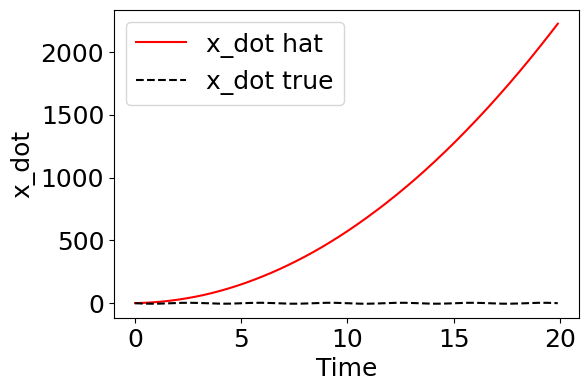

In [36]:
plot_tme(df_states.t, df_states['x_dot'], None, estimated=xhat_fp[4,:], label_var='x_dot')

<Axes: xlabel='Time', ylabel='z'>

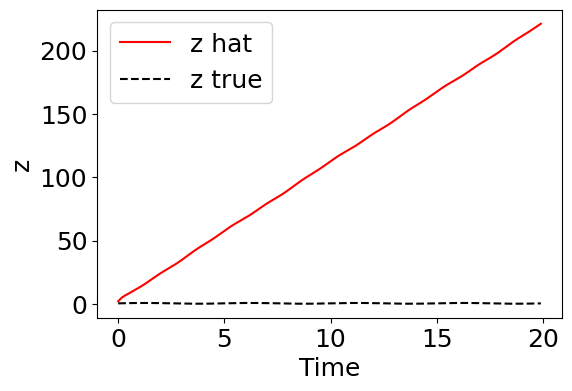

In [37]:
plot_tme(df_states.t, df_states['z'], None, estimated=xhat_fp[5,:], label_var='z')

<Axes: xlabel='Time', ylabel='theta'>

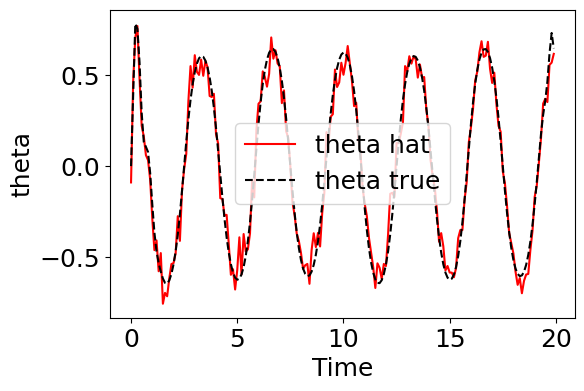

In [38]:
plot_tme(df_states.t, df_states['theta'], None, estimated=xhat_fp[0,:], label_var='theta')

<Axes: xlabel='Time', ylabel='k'>

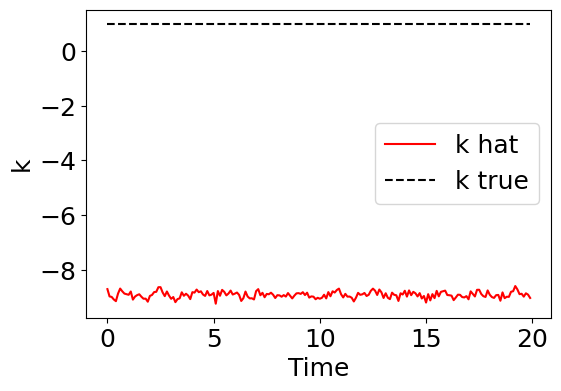

In [39]:
plot_tme(df_states.t, df_states['k'], None, estimated=xhat_fp[6,:], label_var='k')